# Tutorial 1: How Much is Your Wine?

In this tutorial, we will create an end-to-end regression model with the wine review dataset. The API of PyTLC (short for microsoftml_scikit) is compatible with sklearn, so users who are already familiar with scikit-learn can get started right away. There are also some "advanced" techniques which can be helpful for optimal performance:

1. PyTLC pipelines
2. FileDataStream
3. Column operations and roles

This tutorial is organized as following:
## 1. Quick Start
## 2. Wine Review Example
### 2.1 Data Preprocessing - Stream Data from Files
### 2.2 Model Development
### 2.3 Model Evaluation
## 3. Recap

*Let's get started!!*

Note that it would be useful to have this page opened for class referenece:

https://review.docs.microsoft.com/en-us/pytlc/?branch=release_v.0.0.5

## 1. Quick Start

The modeling data can be sourced from several different types. Most array-like structures are supported (e.g. lists, numpy arrays, dataframes, series etc.). Let’s look at a simple example.

In [3]:
import sys
!{sys.executable.replace('python', 'pip') + ' install nimbusml'}
print("wheel installed.")

    100% |████████████████████████████████| 86.7MB 46kB/s  eta 0:00:01
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
wheel installed.


In [4]:
from nimbusml.linear_model import FastLinearClassifier
X = [[1,2,3],[2,3,4],[-1.2,-1,-7]]
Y = [0,0,1]

model = FastLinearClassifier()
model.fit(X,Y)

model.predict(X)

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Using 1 thread to train.
Automatically choosing a check frequency of 1.
Auto-tuning parameters: maxIterations = 499998.
Auto-tuning parameters: L2 = 2.666677E-05.
Auto-tuning parameters: L1Threshold (L1/L2) = 0.
Using best model from iteration 3441.
Not training a calibrator because it is not needed.
Elapsed time: 00:00:03.8671048


0    0
1    0
2    1
Name: PredictedLabel, dtype: int64

We can also use Pipeline to include more than one operators in the model, just like sklearn.

In [5]:
from nimbusml import Pipeline
from nimbusml.preprocessing.missing_values import Handler as Missingval_Handler

model = Pipeline([
                    Missingval_Handler(), # issues handling integers, input needs to be float
                    FastLinearClassifier()
                 ])
model.fit(X,Y)

scores, metrics = model.test(X,Y)
metrics

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Using 1 thread to train.
Automatically choosing a check frequency of 1.
Auto-tuning parameters: maxIterations = 499998.
Auto-tuning parameters: L2 = 2.666677E-05.
Auto-tuning parameters: L1Threshold (L1/L2) = 0.
Using best model from iteration 3505.
Not training a calibrator because it is not needed.
Elapsed time: 00:00:00.5878601


""


## 2. Wine Review Example

In this section, we are trying to develop a prediction model to use the review data and other information of the wine to predict its price. We will use PyTLC's text featurizer to extract numeric features from the review corpus using **pre-trained** language models.

The dataset contains a mix of numeric, categorical and text features. This section will demonstrate how  a pipeline of transforms and trainers to do the following.

-	Process data directly from files!
-	Filter records
-	New : how to apply transforms to just the columns of interest!!
-	Using OneHotVectorizer to encode the categorical features
-	Use of NGramFeaturizer  and WordEmbedding transform (a pre-trained DNN model) to convert text to numeric embeddings.
-	Feature selection using the CountSelector
-	Fitting a regression model

### 2.1 Data Preprocessing - Stream Data from Files

In [6]:
from nimbusml import FileDataStream

# we don't use pandas DataFrame, but FileDataStream to improve performance
ds_train = FileDataStream.read_csv("wine_train.csv")
ds_test = FileDataStream.read_csv("wine_test.csv")
ds_train.head(3)

,Unnamed0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,0.0,Sicily & Sardinia,Etna,None,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [8]:
ds_train.schema

DataSchema([DataColumn(name='Unnamed0', type='I8', pos=0),
    DataColumn(name='country', type='TX', pos=1),
    DataColumn(name='description', type='TX', pos=2),
    DataColumn(name='designation', type='TX', pos=3),
    DataColumn(name='points', type='I8', pos=4),
    DataColumn(name='price', type='R8', pos=5),
    DataColumn(name='province', type='TX', pos=6),
    DataColumn(name='region_1', type='TX', pos=7),
    DataColumn(name='region_2', type='TX', pos=8),
    DataColumn(name='taster_name', type='TX', pos=9),
    DataColumn(name='taster_twitter_handle', type='TX', pos=10),
    DataColumn(name='title', type='TX', pos=11),
    DataColumn(name='variety', type='TX', pos=12),
    DataColumn(name='winery', type='TX', pos=13)], header=True)

### 2.2 Model Development

Based on the data type, we want to develop a pipeline that applies different operators onto different columns. Note that this pipeline can defintely be improved to achieve better accuracy.  

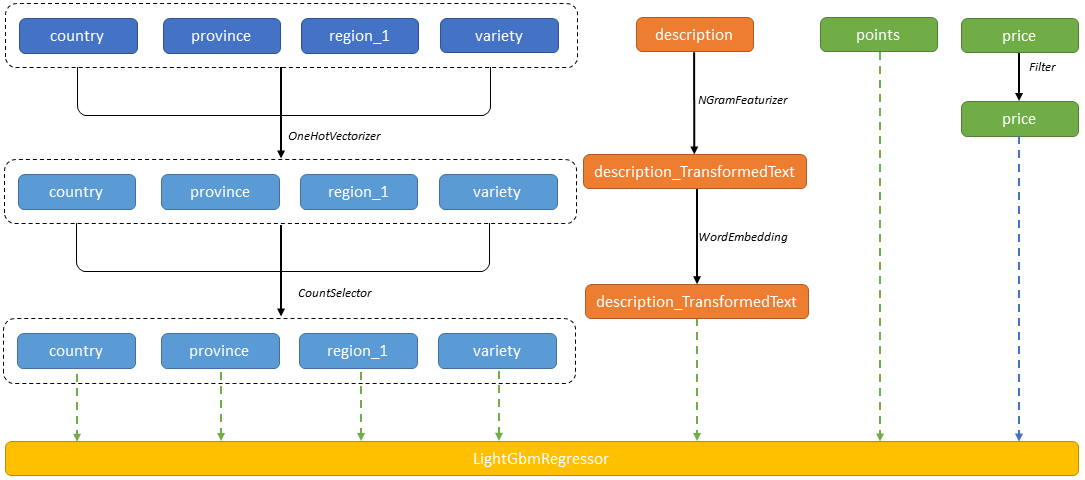

In [3]:
from IPython.display import Image
Image(filename='1.png')

In [9]:
from nimbusml.preprocessing.missing_values import Filter as Missingval_Filter
from nimbusml.feature_extraction.categorical import OneHotVectorizer
from nimbusml.feature_selection import CountSelector
from nimbusml.feature_extraction.text import NGramFeaturizer
from nimbusml.feature_extraction.text import WordEmbedding
from nimbusml.ensemble import LightGbmRegressor
from nimbusml import Role

# tk = TakeFilter(count = 100) #Always suggested to start with a TakeFilter to quickly examine the pipeline

ft = Missingval_Filter()                   << ['price']
# ft = Missingval_Filter(columns = ['price']) #Equivalent

onv = OneHotVectorizer()                   << ['country', 'province', 'region_1', 'variety']
cs = CountSelector(count = 2)              << ['country', 'province', 'region_1', 'variety']

ng = NGramFeaturizer(output_tokens = True) << ['description']
we = WordEmbedding(model_kind = 'Sswe')    << ['description_TransformedText']
lgm = LightGbmRegressor()                  << {'Feature': ['country', 'province', 'region_1', 'variety', 
                                               'description_TransformedText', 'points'],
                                               'Label': 'price'}

# lgm = LightGbmRegressor(feature = ['country', 'province', 'region_1', 'variety', 
#                                                'description_TransformedText', 'points'],
#                         label = 'price') #Equivalent

model = Pipeline([ft, onv, cs, ng, we, lgm])
model.fit(ds_train)

  Bad value at line 21521 in column price
  Bad value at line 51400 in column price
Processed 100004 rows with 2 bad values and 6 format errors
  Bad value at line 21521 in column price
  Bad value at line 51400 in column price
Processed 100004 rows with 2 bad values and 6 format errors
Selected 40 slots out of 43 in column 'country'
Selected 349 slots out of 408 in column 'province'
Selected 1024 slots out of 1190 in column 'region_1'
Selected 520 slots out of 664 in column 'variety'
Total number of slots selected: 1933
  Bad value at line 21521 in column price
  Bad value at line 51400 in column price
Processed 100004 rows with 2 bad values and 5 format errors
  Bad value at line 21521 in column price
  Bad value at line 51400 in column price
Processed 100004 rows with 2 bad values and 5 format errors
  Bad value at line 21521 in column price
  Bad value at line 51400 in column price
Processed 100004 rows with 2 bad values and 5 format errors
sentiment.emd: Downloaded 4096 bytes out 

Users can specify the input columns for the transform using:

            OneHotVectorizer(columns = ['country', 'province', 'region_1', 'variety'])
or

            OneHotVectorizer() << ['country', 'province', 'region_1', 'variety']
By default, the output column names are the same as the input (overwrite). Users can also specify the new output columns names, therefore, both the input and output columns are preserved.

            OneHotVectorizer(columns = {'country_out': 'country', 'variety_out': 'variety'})
or

            OneHotVectorizer() << {'country_out': 'country', 'variety_out': 'variety'}

For learners, users need to specify the roles for the columns by using:

            FastForestRegressor(feature = ['country', 'province'], label = 'price')

The feature, lable are the "roles" users need to specify. Notice that, it is equivalent to use the shift operator:

            FastForestRegressor() << {Role.Feature: ['country', 'province'], Role.Label: 'price'}

We have well-known names for columns.  For example, column named as “Features” would be treated as a training data.  Column named “Label” will be treated as Label by default . Also, I believe those are case sensitive.

We can also plot the pipeline using the plot function.

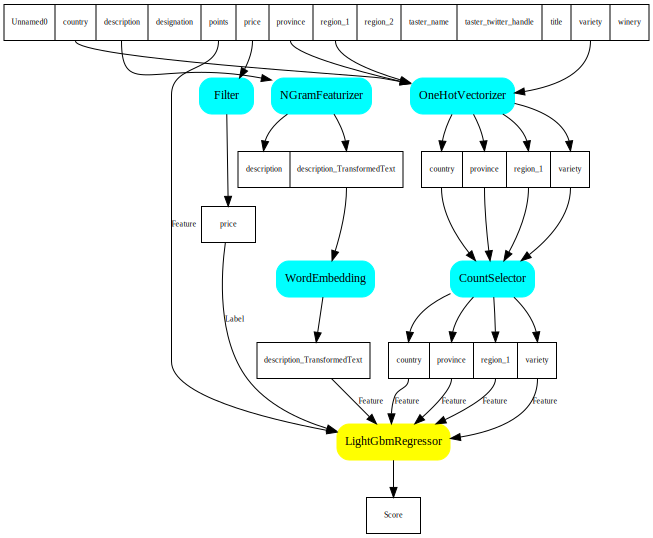

In [10]:
from nimbusml.utils.exports import img_export_pipeline
fig = img_export_pipeline(model,ds_train) 
fig
# fig.render("ppl1.png") # save this image to files

### 2.3 Model Evaluation

In [11]:
metrics, scores = model.test(ds_test, output_scores=True)
metrics

,L1(avg),L2(avg),RMS(avg),Loss-fn(avg),R Squared
0,14.110983,1223.179568,34.973984,1223.179585,0.269005


Thru better feature engineering and parameterization, the R Squaraed can be improved to **0.60**.

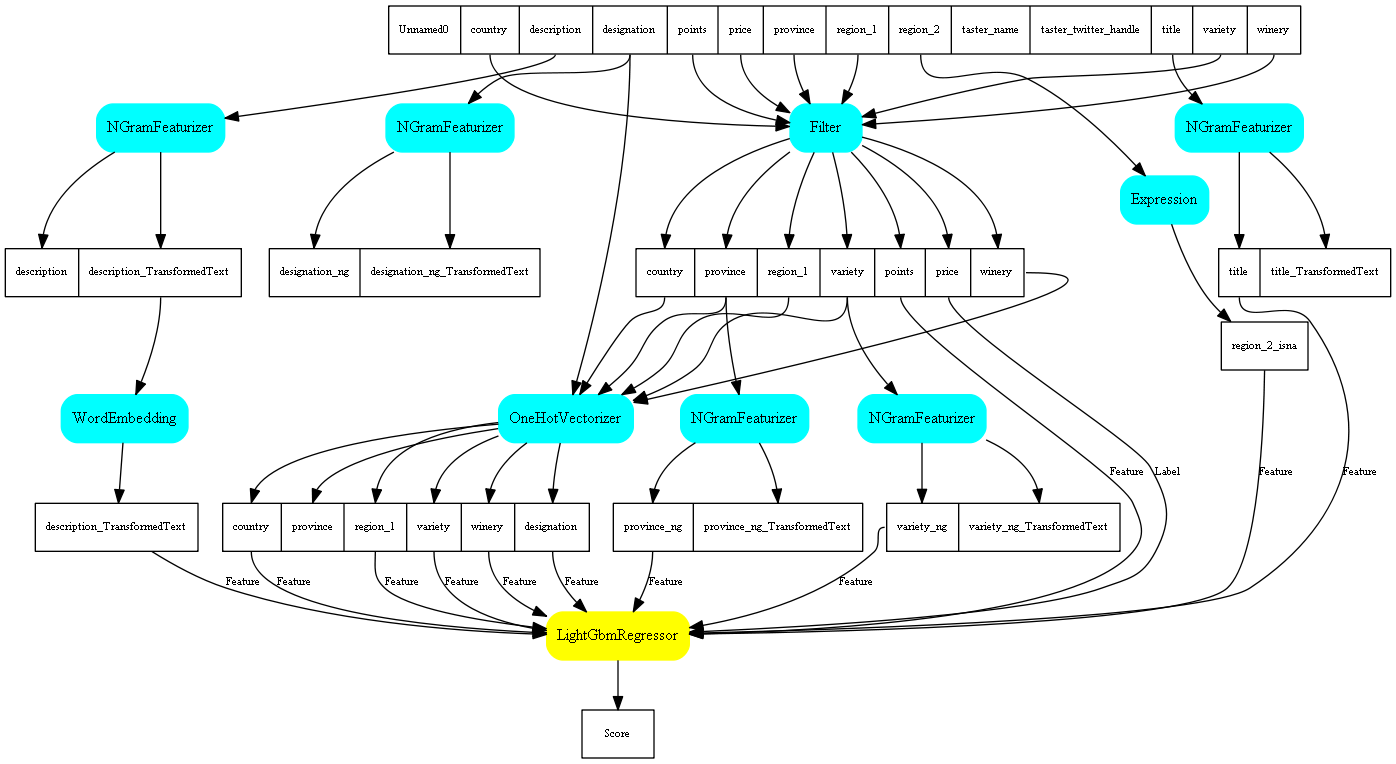

In [4]:
Image(filename='2.png')

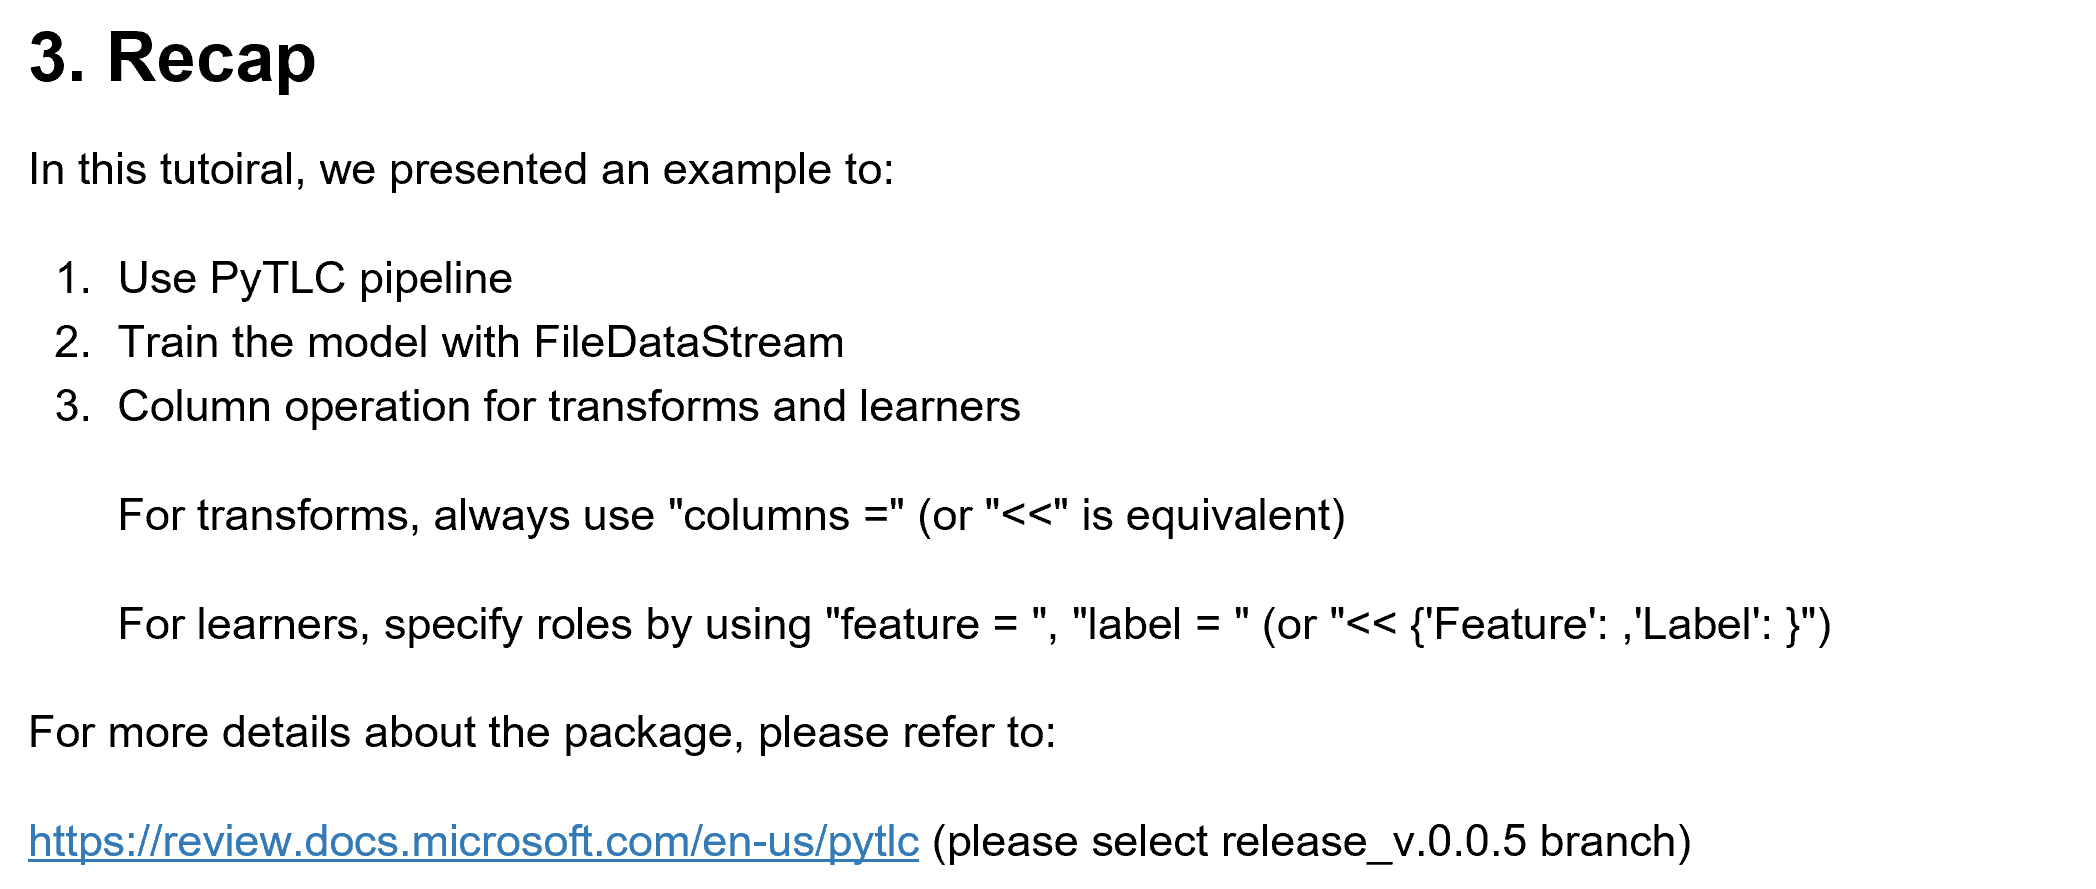

In [5]:
Image(filename='3.png')